In [2]:
from cellrank.datasets import bone_marrow
import matplotlib.pyplot as plt

import project

In [3]:
adata = bone_marrow()
adata

  0%|          | 0.00/370M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [4]:
adata.shape

(5780, 27876)

## Velocity estimation using scvelo

In [6]:
project.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

project.pp.pca(adata)
project.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
project.pp.moments(adata, n_pcs=None, n_neighbors=None)

In [7]:
# import scanpy as sc
# import scvelo as scv
# sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
# scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

In [8]:
project.tl.recover_dynamics(adata, n_jobs=-1)
project.tl.velocity(adata, mode="dynamical")
project.tl.latent_time(adata)

recovering dynamics (using 16/16 cores)


  0%|          | 0/613 [00:00<?, ?gene/s]

    finished (0:04:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


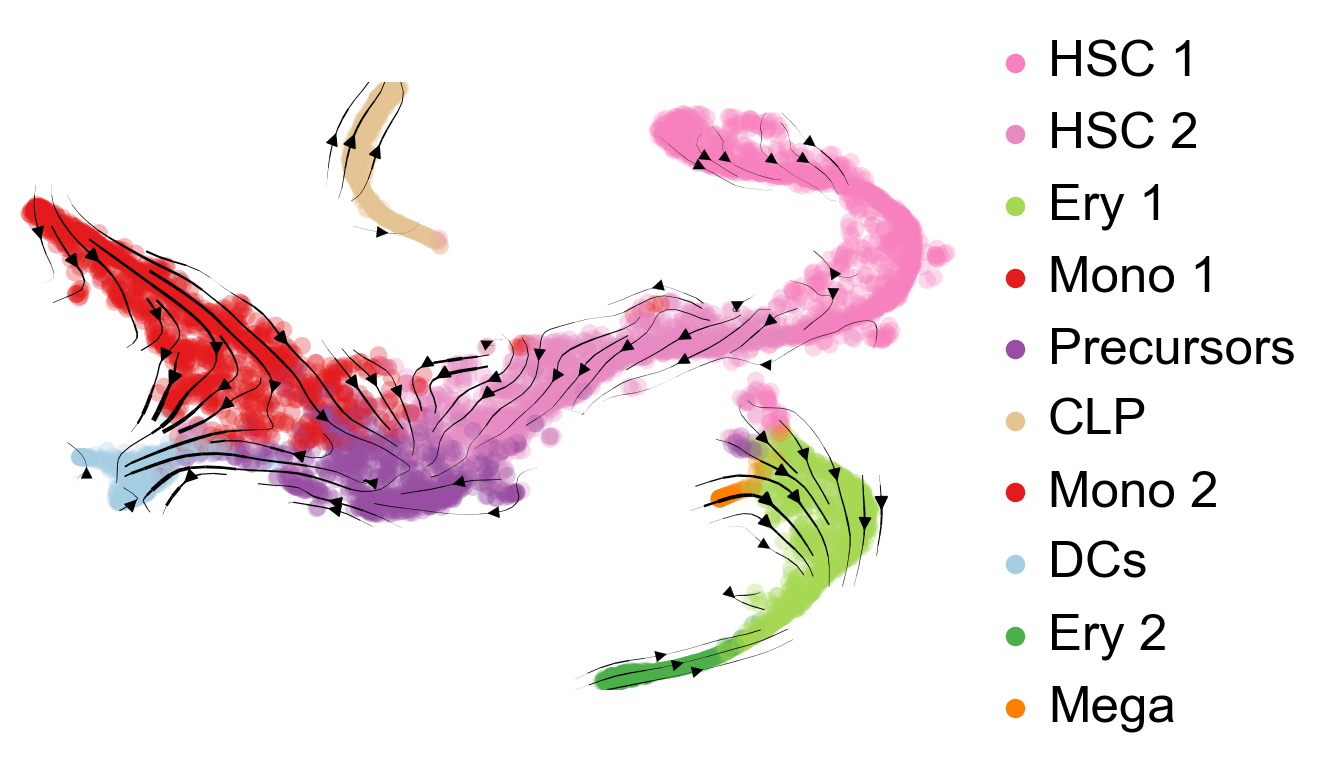

In [9]:
fig_kwargs = {"color": ["clusters"], "legend_loc": "right", "dpi": 100, "title": ""}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
project.tl.velocity_graph(adata)
project.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [11]:
# genes = ["ANGPT1", "RBPMS"]
genes = adata.var["fit_likelihood"].sort_values(ascending=False)[:2].index.to_list()

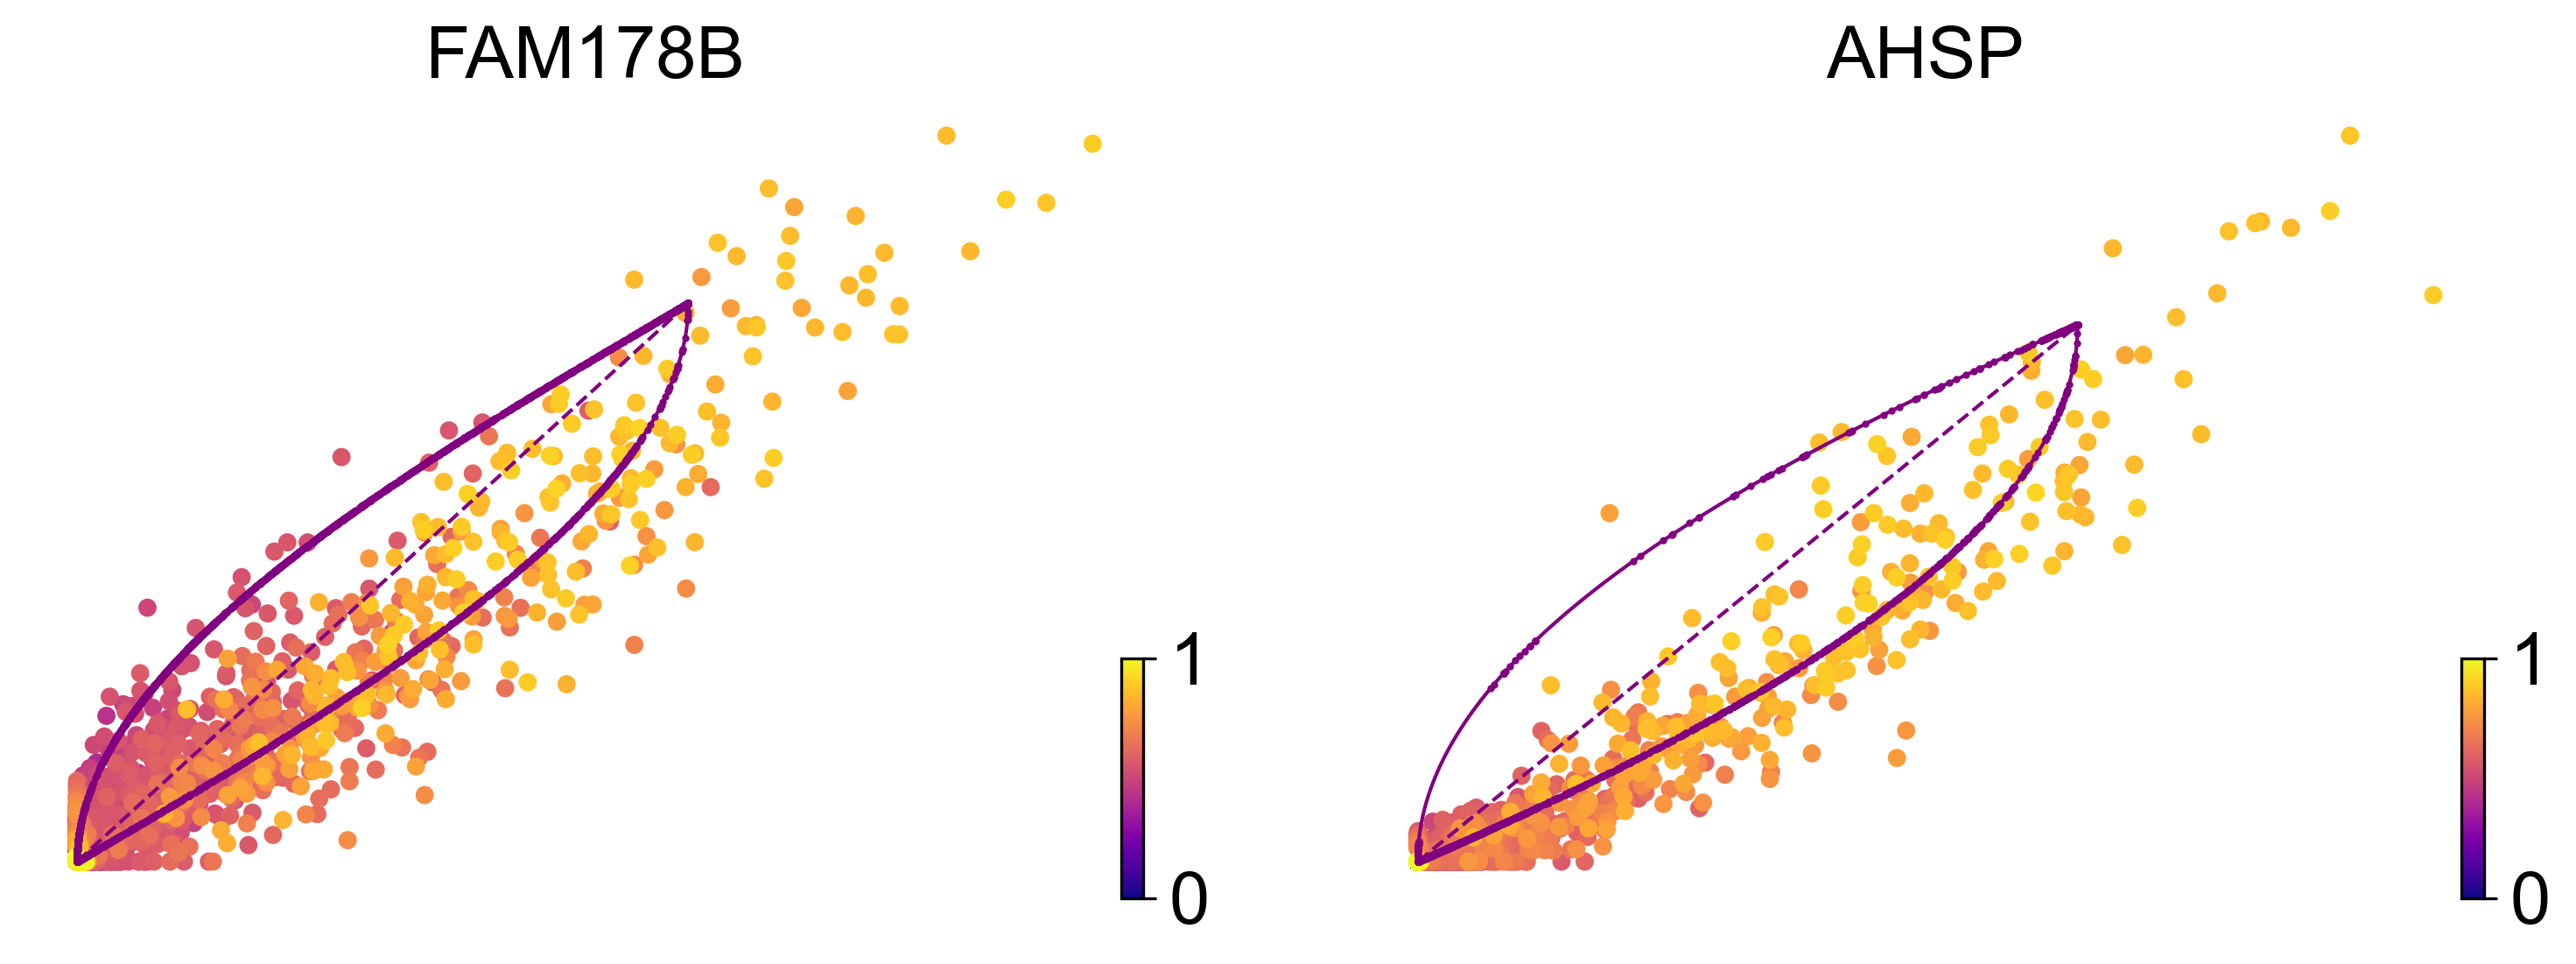

In [12]:
fig_kwargs = {
    "basis": genes,
    "color": "palantir_pseudotime",
    "color_map": "plasma",
    "frameon": False,
    "s": 100,
    "dpi": 150,
}
project.pl.scatter(adata, **fig_kwargs)

high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [15]:
indices, _ = project.gv.adj_to_knn(adata.obsp["connectivities"])
adata.uns["neighbors"]["indices"] = indices

In [16]:
project.gv.mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

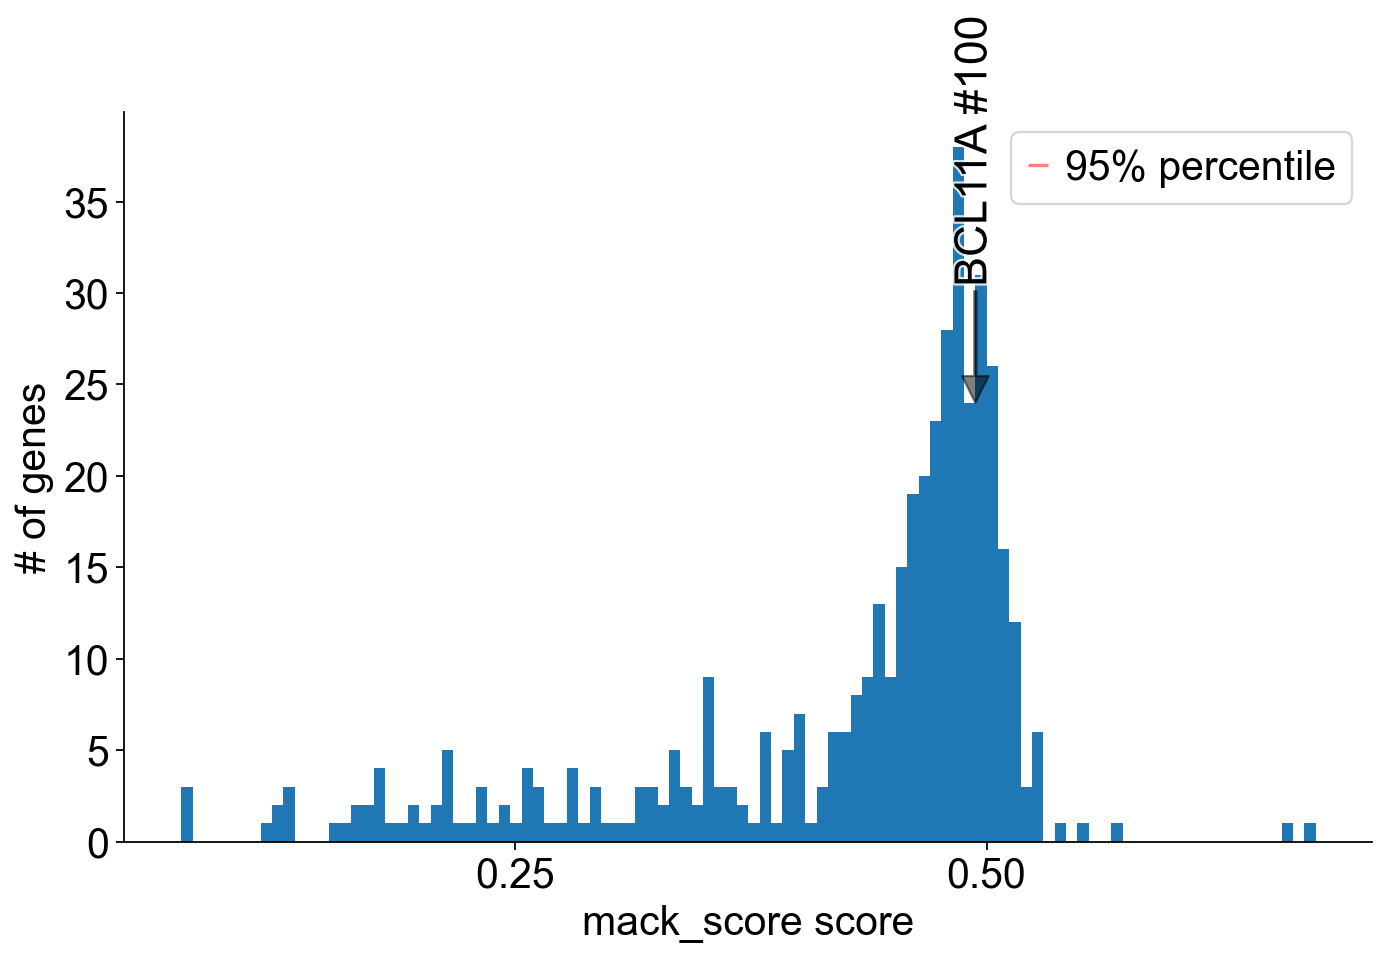

In [17]:
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = project.pl.gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

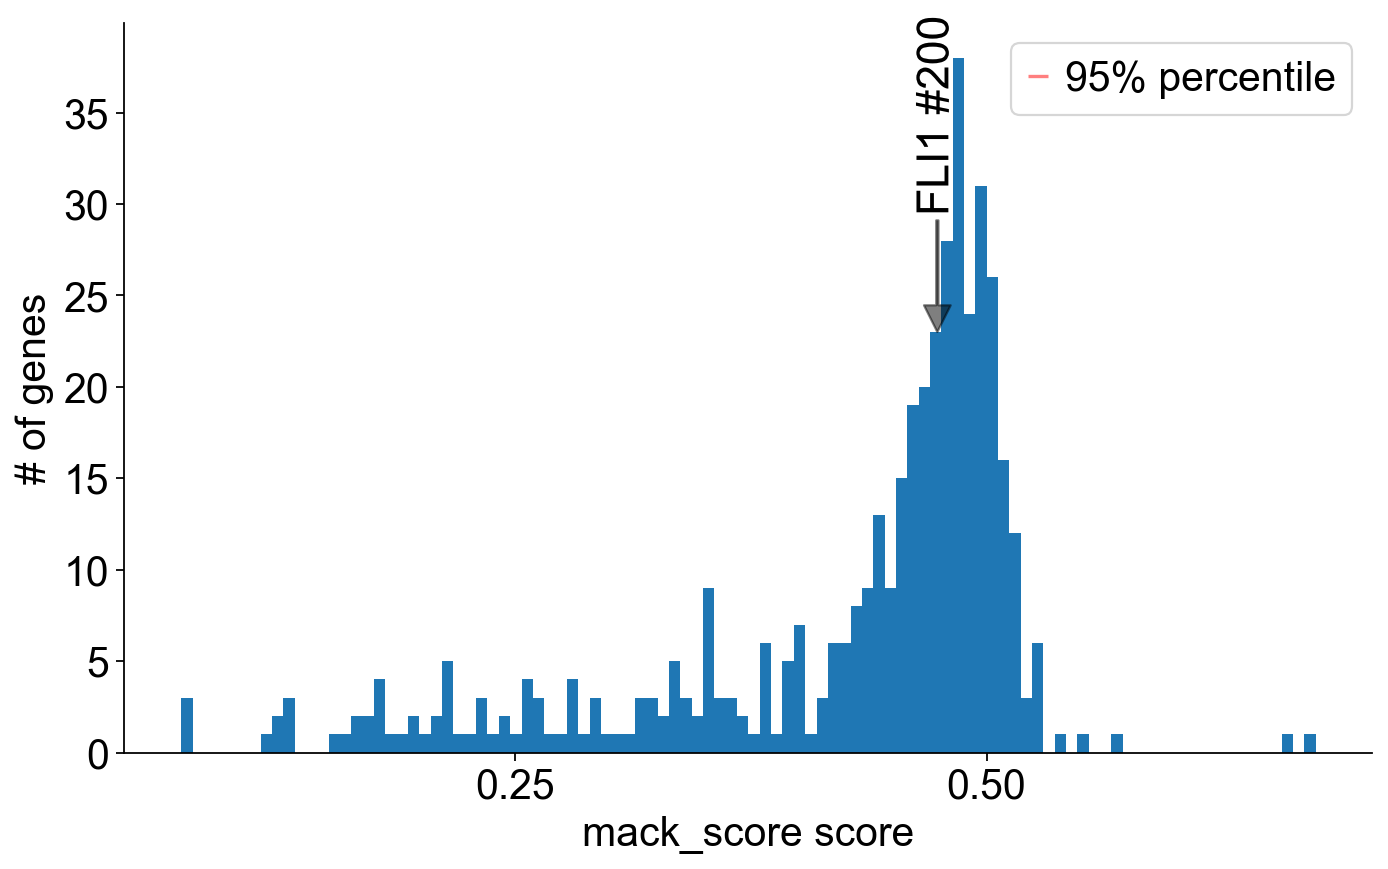

In [18]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = project.pl.gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|█| 5780/5780 [00:41<00:00, 138
C:\Users\sleep\Desktop\assignment\third\02712\project\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


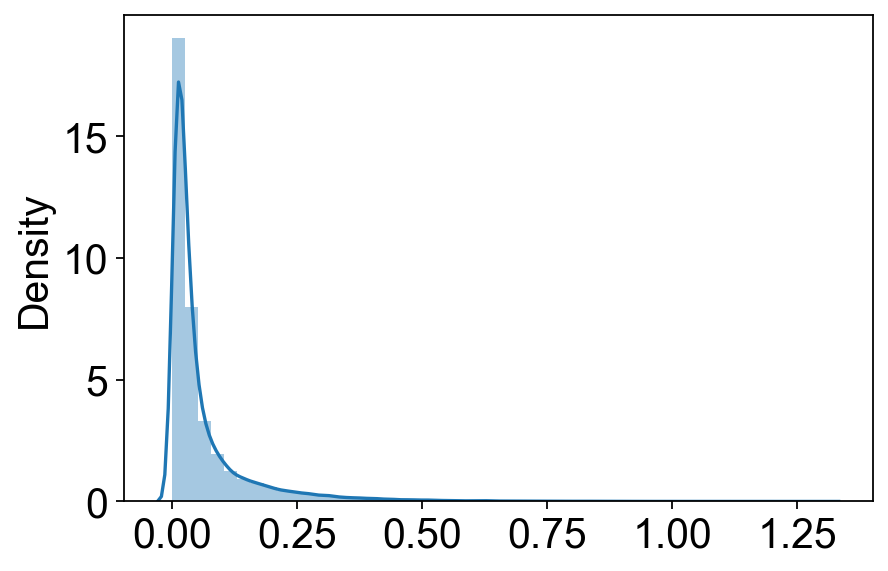

In [19]:
from graphvelo.graph_velocity import GraphVelo
#gv = project.gv.GraphVelo(adata, gene_subset=macKG)
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [20]:
adata.layers["velocity_gvs"] = gv.project_velocity(adata.layers["Ms"])
adata.layers["velocity_gvu"] = gv.project_velocity(adata.layers["Mu"])
adata.obsm["gv_pca"] = gv.project_velocity(adata.obsm["X_pca"])
adata.obsm["gv_tsne"] = gv.project_velocity(adata.obsm["X_tsne"])

projecting velocity vector to low dimensional embedding: 100%|█| 5780/5780 [00
projecting velocity vector to low dimensional embedding: 100%|█| 5780/5780 [00
projecting velocity vector to low dimensional embedding: 100%|█| 5780/5780 [00
projecting velocity vector to low dimensional embedding: 100%|█| 5780/5780 [00


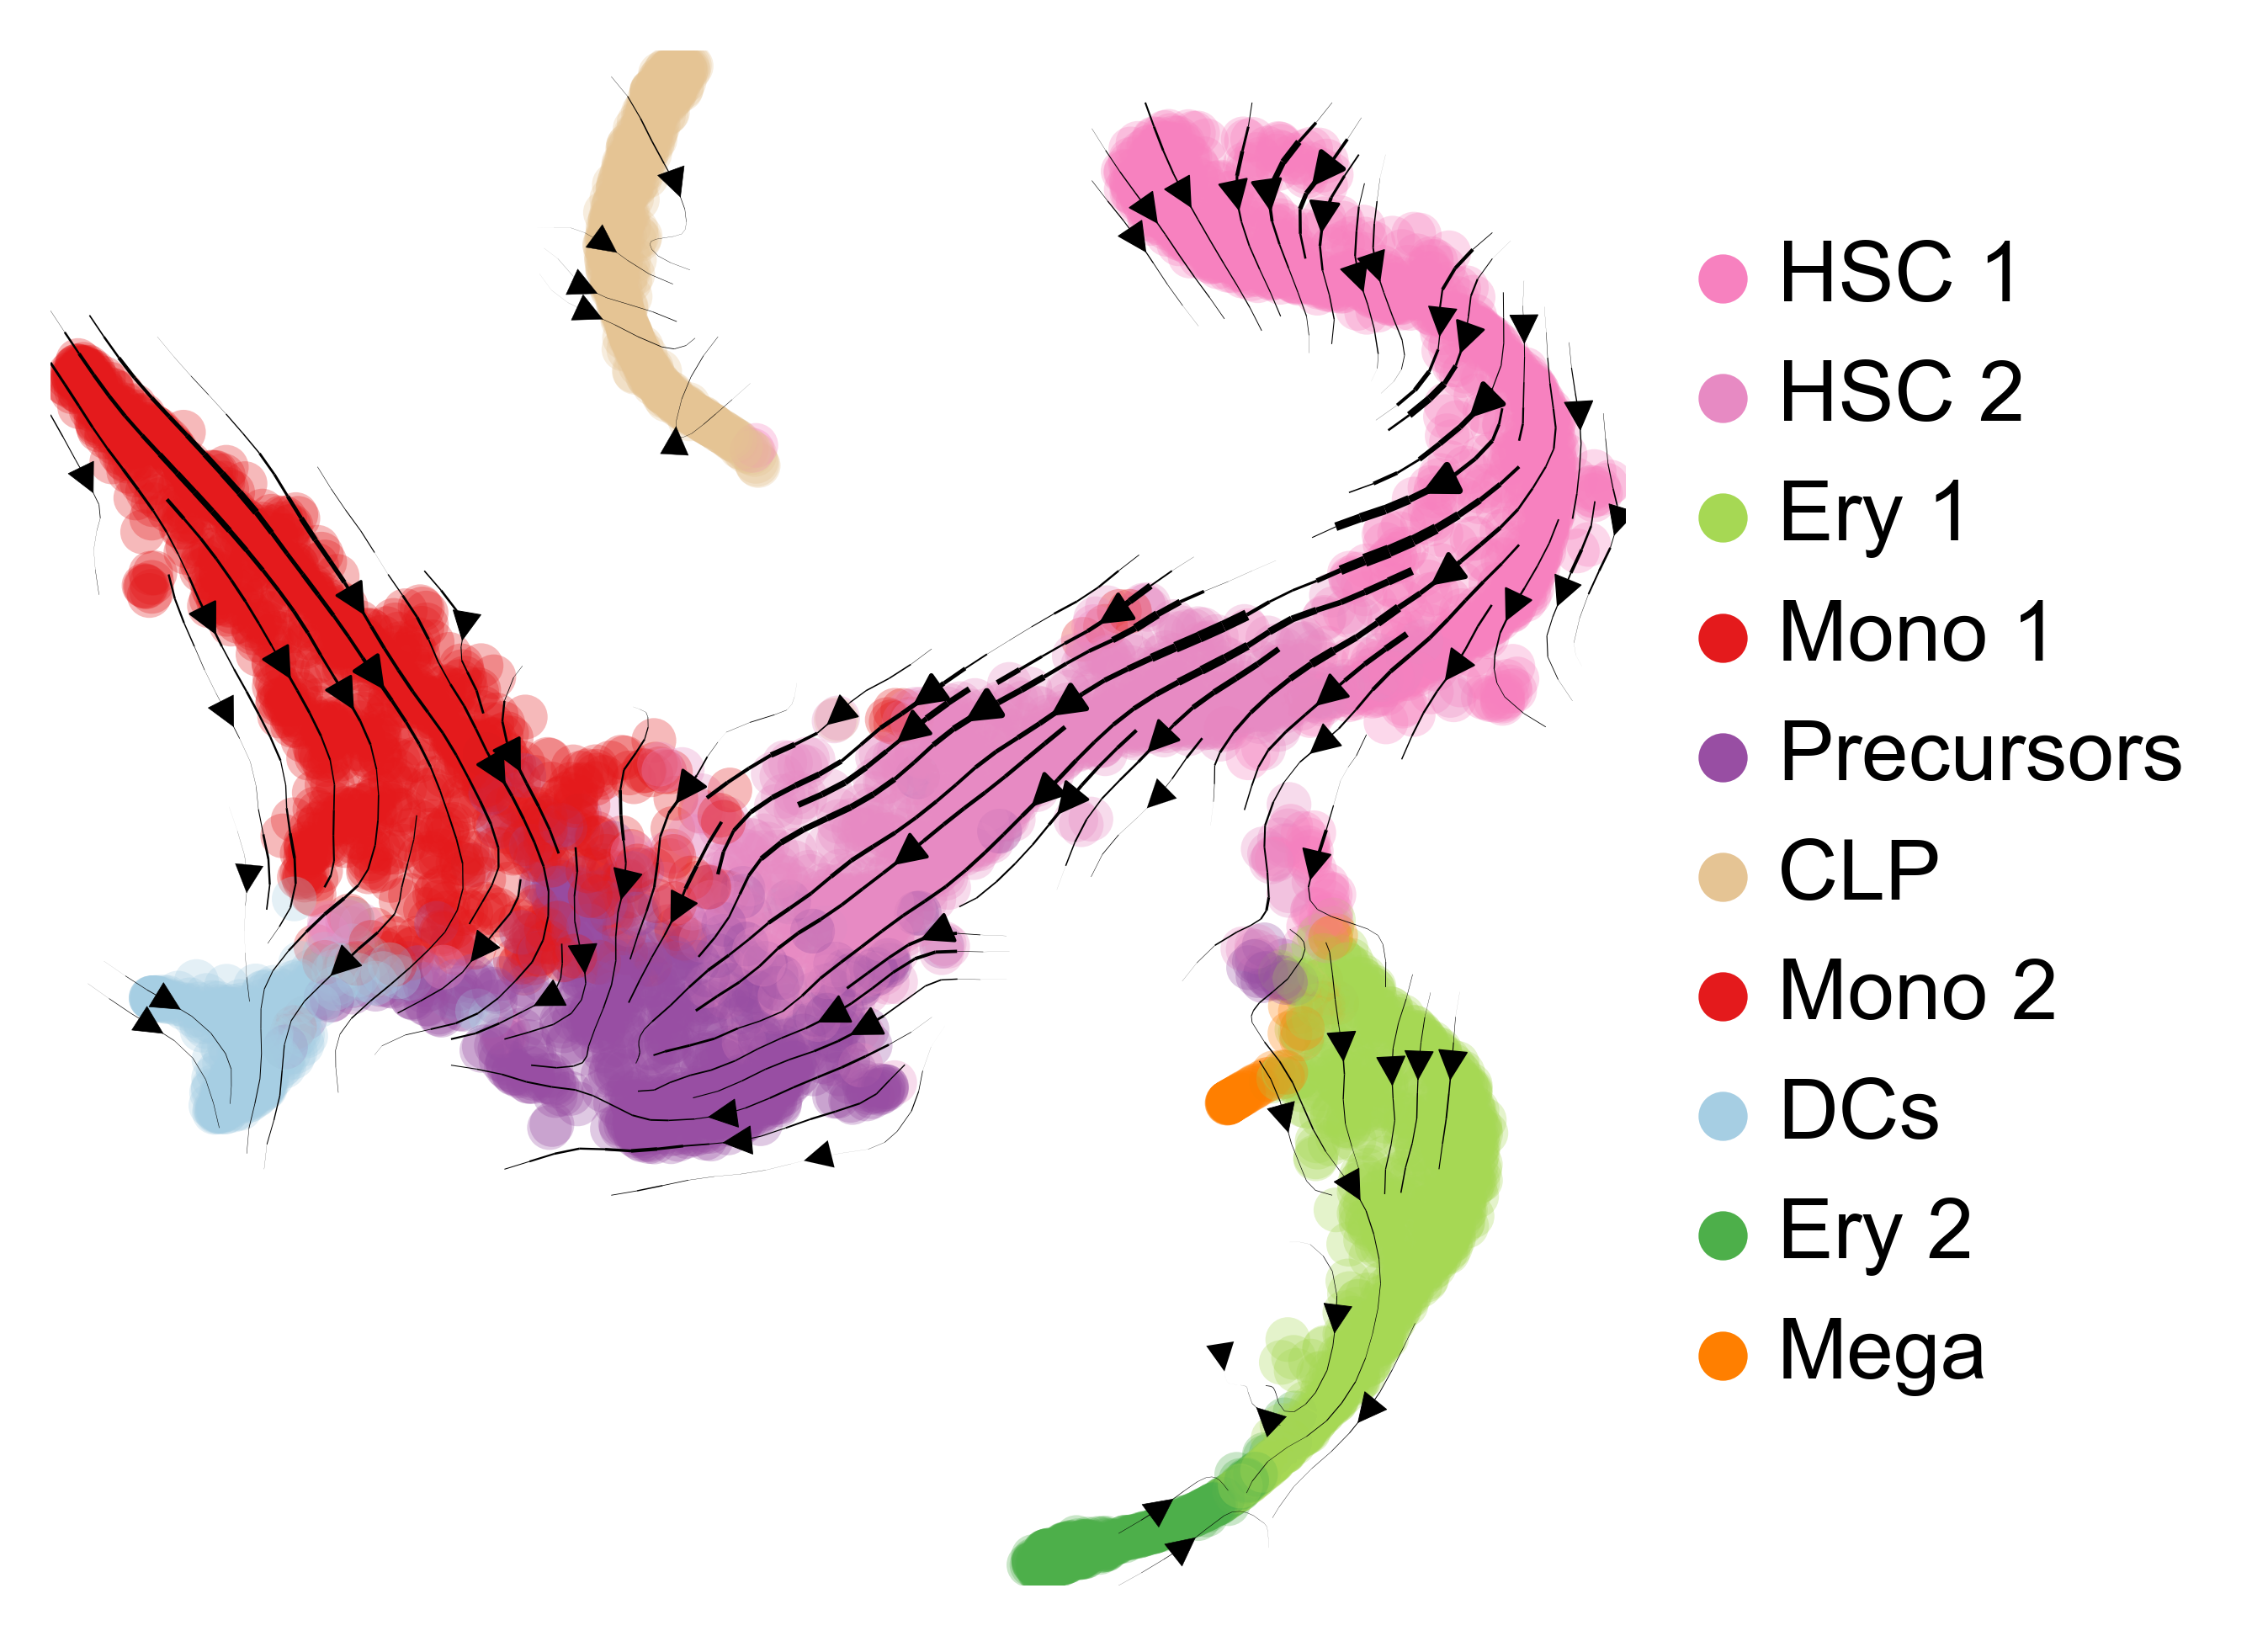

In [21]:
fig_kwargs = {
    "color": ["clusters"],
    "X": adata.obsm["X_tsne"],
    "V": adata.obsm["gv_tsne"],
    "legend_loc": "right",
    "dpi": 300,
    "title": "",
    "legend_fontsize": 12,
    "figsize": (4, 4),
}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
project.pl.velocity_embedding_stream(adata, **fig_kwargs)

Plotting velocity in phase diagram: 100%|███████| 2/2 [00:03<00:00,  1.99s/it]


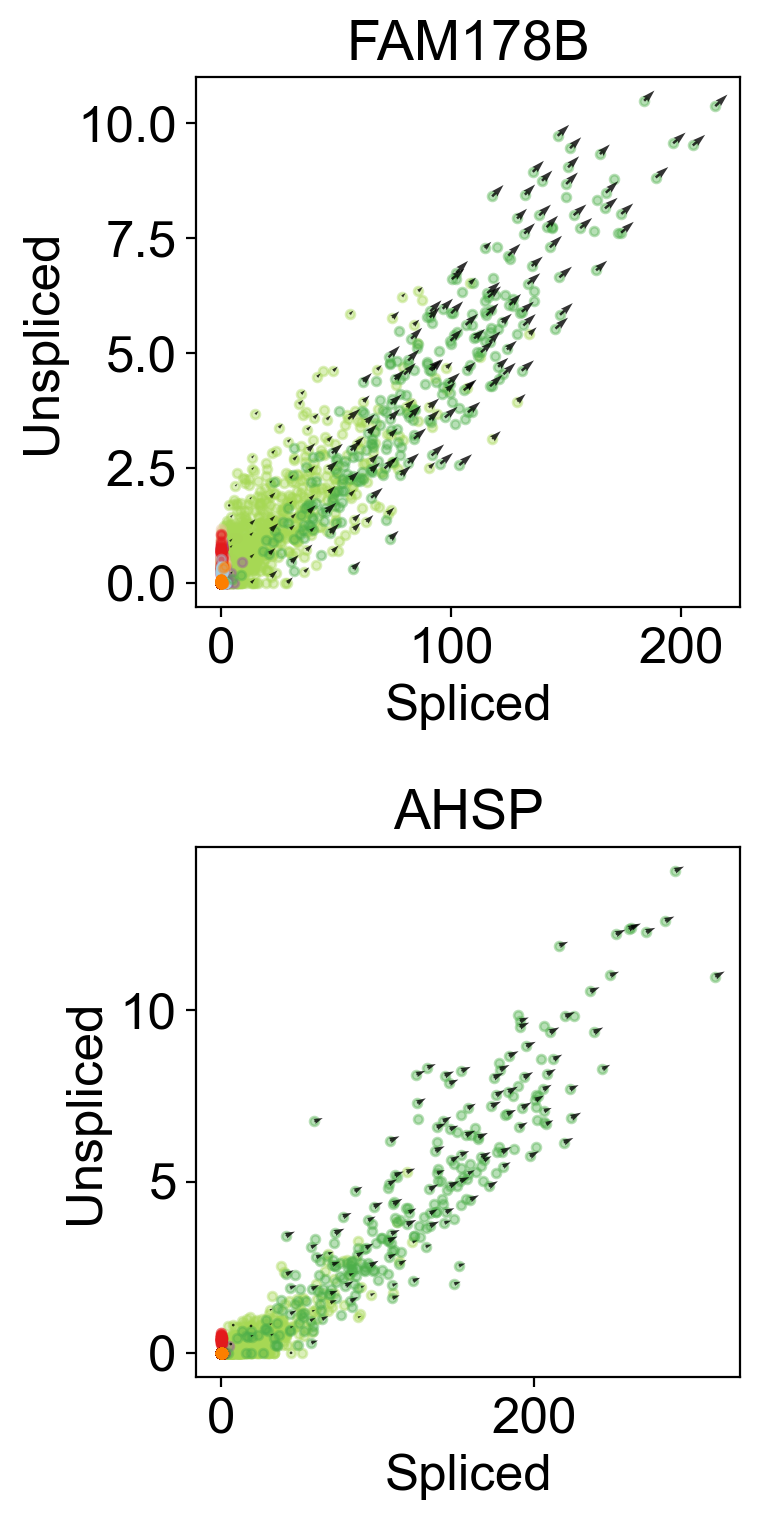

In [22]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity_gvs",
    "vu_layer": "velocity_gvu",
    "pointsize": 10,
    "ncols": 1,
    "scale": 3,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = project.pl.plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv100_phase.pdf', dpi=300, transparent=True)
plt.show()

Plotting velocity in phase diagram: 100%|███████| 2/2 [00:03<00:00,  1.92s/it]


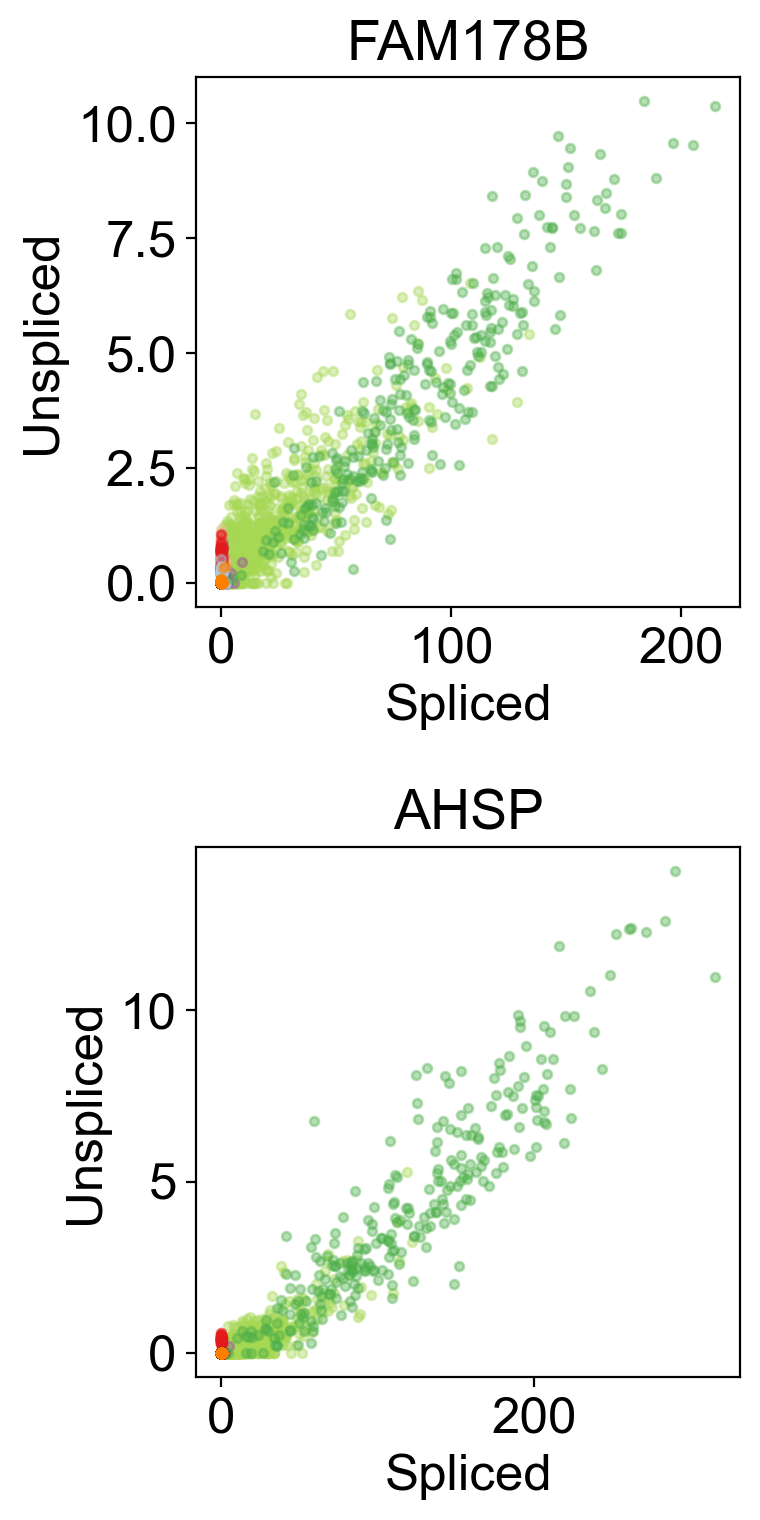

In [23]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity",
    "vu_layer": "velocity_u",
    "pointsize": 10,
    "ncols": 1,
    "scale": 1,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = project.pl.plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_hspc/genes_phase_velo.pdf', dpi=300, transparent=True)
plt.show()

In [24]:

import scvelo as scv
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis="pca")


computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [25]:
# single CBC score calculation
# calculate CBC score for both scVelo and GraphVelo with the same transition of HSC -> Ery
from project.graphvelo.metric import cross_boundary_correctness_one_transition
transition = ("HSC_1", "Ery_1")
V_data_scvelo = adata.obsm["velocity_pca"]

cbc_score_sc = cross_boundary_correctness_one_transition(
    adata,
    transition,
    V_data_scvelo,
    annotation_key="clusters",
    reduce_space_key="X_pca",   
    neighbor_key="neighbors"
)

cbc_score_gv = cross_boundary_correctness_one_transition(
    adata,
    transition,
    V_data = adata.obsm["gv_pca"],
    annotation_key="clusters",
    reduce_space_key="X_pca",
    neighbor_key="neighbors"
)

print("CBC score scVelo:", cbc_score_sc)
print("CBC score GraphVelo:", cbc_score_gv)

CBC score scVelo: -0.01474482327742224
CBC score GraphVelo: 0.02949872477549702


In [26]:
# cbc for all transition

transitions = [
    ("HSC_1", "HSC_2"),          # stem cell subtypes
    ("HSC_2", "Precursors"),     # multipotent progenitors
    ("Precursors", "Ery_1"),     # erythroid lineage start
    ("Ery_1", "Ery_2"),          # erythroid maturation
    ("Precursors", "Mono_1"),    # monocyte lineage start
    ("Mono_1", "Mono_2"),        # monocyte maturation
    ("Mono_2", "DCs"),           # dendritic cell differentiation
    ("Precursors", "CLP"),       # lymphoid progenitor branch
    ("Precursors", "Mega") ]      # megakaryocyte branch
V_data_scvelo = adata.obsm["velocity_pca"]
cbc_sc_all = []
cbc_gv_all = []
for transition in transitions:
    cbc_score_sc = cross_boundary_correctness_one_transition(
        adata,
        transition,
        V_data_scvelo,
        annotation_key="clusters",
        reduce_space_key="X_pca",   
        neighbor_key="neighbors"
     )

    cbc_score_gv = cross_boundary_correctness_one_transition(
        adata,
        transition,
        V_data = adata.obsm["gv_pca"],
        annotation_key="clusters",
        reduce_space_key="X_pca",
        neighbor_key="neighbors"
     )    
    cbc_sc_all.append(cbc_score_sc)
    cbc_gv_all.append(cbc_score_gv)


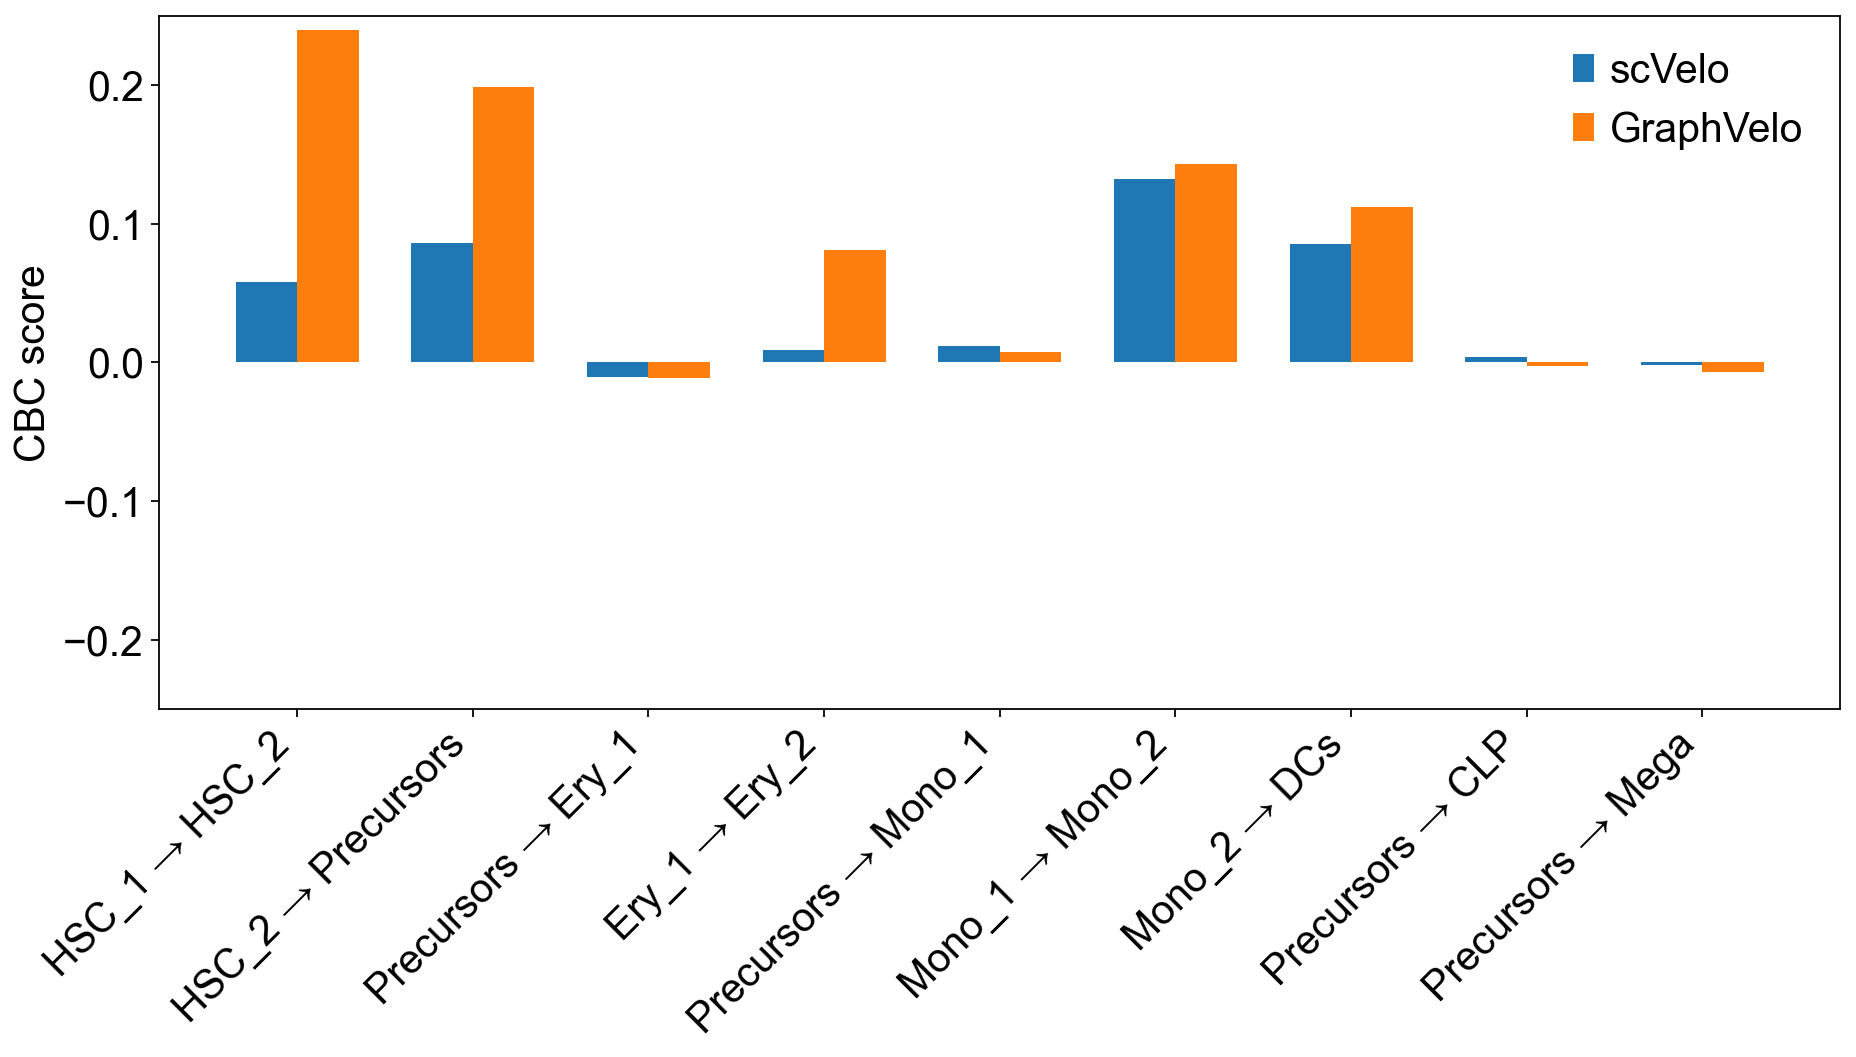

In [75]:
# CBC plot for each transition
import matplotlib.pyplot as plt
import numpy as np

# Convert transitions to nice labels
transitions_list = [f"{a} → {b}" for a, b in transitions]

# data
sc = np.array(cbc_sc_all)
gv = np.array(cbc_gv_all)

x = np.arange(len(transitions_list))
width = 0.35

plt.figure(figsize=(12,7))

plt.bar(x - width/2, sc, width, label="scVelo", color="#1f77b4")
plt.bar(x + width/2, gv, width, label="GraphVelo", color="#ff7f0e")

plt.xticks(x, transitions_list, rotation=45, ha="right")
plt.ylabel("CBC score")
plt.ylim(-0.25, 0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [77]:
adata.obs["clusters"].unique()

['Ery_1', 'HSC_1', 'Mono_1', 'Precursors', 'Mega', 'HSC_2', 'Mono_2', 'Ery_2', 'DCs', 'CLP']
Categories (10, object): ['HSC_1', 'HSC_2', 'Ery_1', 'Mono_1', ..., 'Mono_2', 'DCs', 'Ery_2', 'Mega']

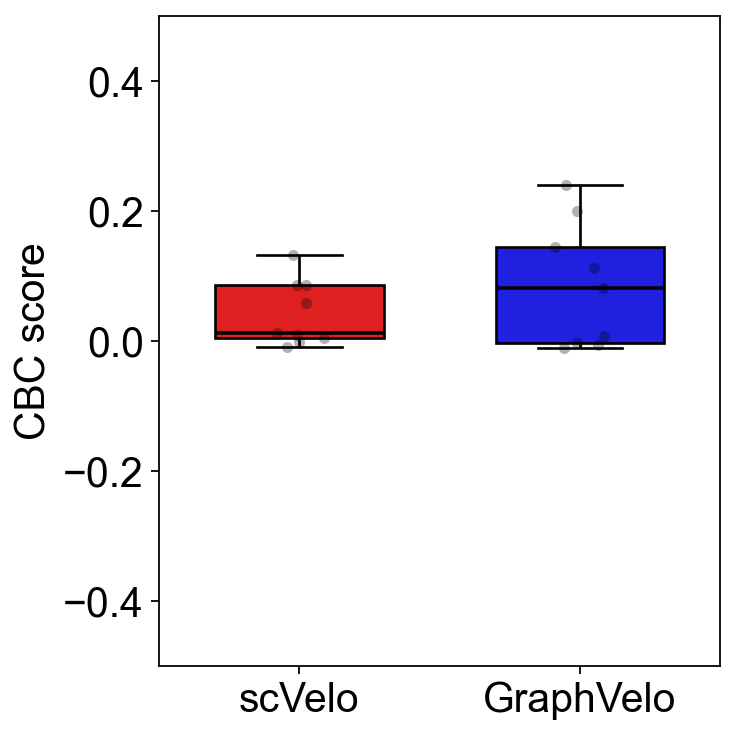

In [81]:
# CBC plot for transition distribution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "CBC": np.concatenate([sc, gv]),
    "Method": ["scVelo"] * len(sc) + ["GraphVelo"] * len(gv)
})

plt.figure(figsize=(5,5))

sns.boxplot(
    data=df,
    x="Method",
    y="CBC",
    palette={"scVelo": "red", "GraphVelo": "blue"},
    width=0.6,
    showcaps=True,
    boxprops=dict(edgecolor="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    medianprops=dict(color="black", linewidth=1.6)
)
sns.stripplot(
    x='Method',
    y='CBC',
    data=df,
    color='black',
    alpha=0.3,
    jitter=True
)


plt.ylim(-0.5, 0.5)
plt.ylabel("CBC score")
plt.xlabel("")
plt.tight_layout()
plt.show()


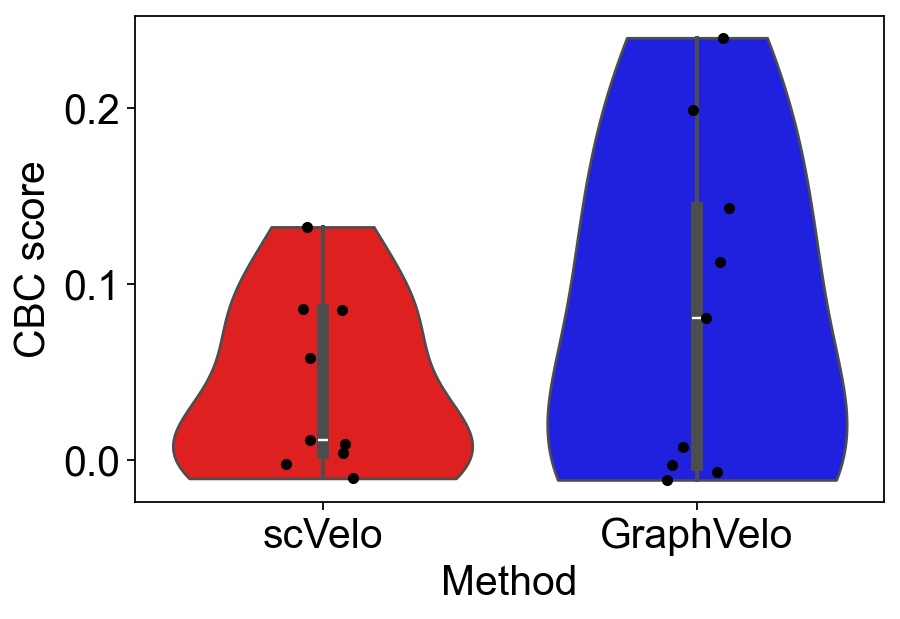

In [89]:
sns.violinplot(
    data=df,
    x="Method",
    y="CBC",
    palette={"scVelo": "red", "GraphVelo": "blue"},
    cut=0,                 
    inner = "box",            
    linewidth=1.2
)

sns.stripplot(
    data=df,
    x="Method",
    y="CBC",
    color="black",
    alpha=1,
    jitter=True
)
plt.ylabel("CBC score")

plt.show()

In [30]:
# Calculate degradation rates 
from project.graphvelo.metric import calculate_degradation_graphvelo
calculate_degradation_graphvelo(
    adata,
    splice_key="Ms",          # spliced counts
    unsplice_key="Mu",        # unspliced counts
    velocity_key="velocity_gvs",  # GraphVelo spliced velocity
    degradation_key="graphvelo_degradation"
)

scvelo_gamma = adata.var['fit_gamma']  # shape: (n_genes,)
print(scvelo_gamma.head())

index
TNFRSF18   NaN
SLC35E2B   NaN
MORN1      NaN
MIR34A     NaN
NPPA       NaN
Name: fit_gamma, dtype: float64


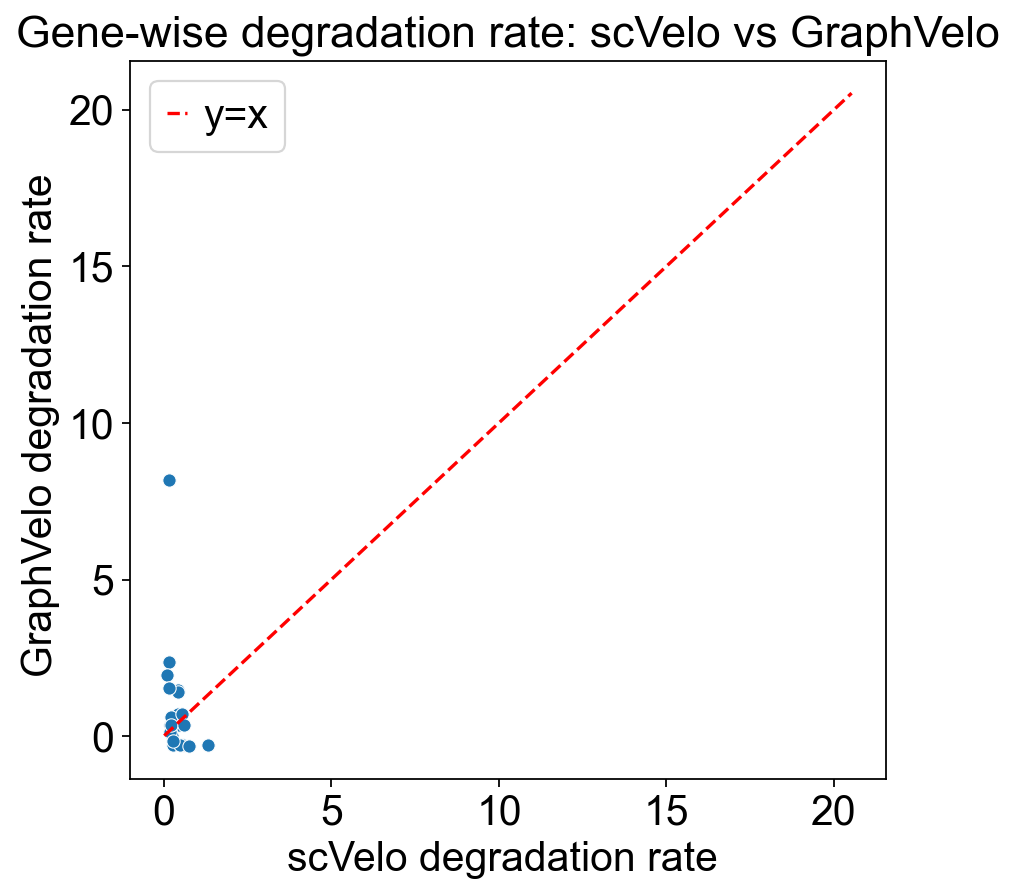

In [91]:
# plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


gamma_gv = np.mean(adata.layers['graphvelo_degradation'], axis=0)
gamma_gv = pd.Series(gamma_gv, index=adata.var_names)


gamma_scv = adata.var['fit_gamma']

# Ensure common genes
common_genes = gamma_scv.index.intersection(gamma_gv.index)
gamma_scv = gamma_scv.loc[common_genes]
gamma_gv = gamma_gv.loc[common_genes]


plt.figure(figsize=(6,6))
sns.scatterplot(x=gamma_scv, y=gamma_gv)
plt.plot([gamma_scv.min(), gamma_scv.max()],
         [gamma_scv.min(), gamma_scv.max()],
         color='red', linestyle='--', label='y=x')
plt.xlabel('scVelo degradation rate ')
plt.ylabel('GraphVelo degradation rate ')
plt.title('Gene-wise degradation rate: scVelo vs GraphVelo')
plt.legend()
plt.tight_layout()
plt.show()


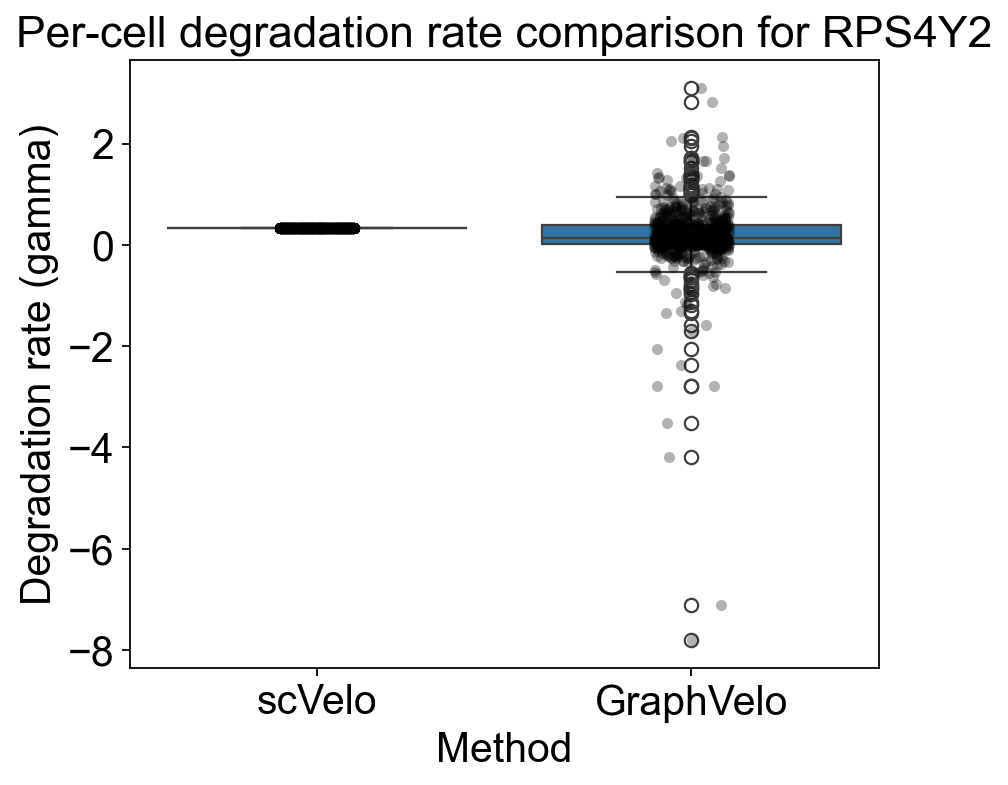

In [93]:
# for single gene degradation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gene = "RPS4Y2"

gv_gamma_cells = adata.layers['graphvelo_degradation'][:, adata.var_names.get_loc(gene)]

scv_gamma_cells = np.full(adata.n_obs, adata.var.loc[gene, 'fit_gamma'])

df_plot = pd.DataFrame({
    'cell': adata.obs_names,
    'scVelo': scv_gamma_cells,
    'GraphVelo': gv_gamma_cells
})

# Melt for seaborn
df_melt = df_plot.melt(id_vars='cell', value_vars=['scVelo', 'GraphVelo'],
                       var_name='Method', value_name='Degradation')

plt.figure(figsize=(6,5))
sns.boxplot(x='Method', y='Degradation', data=df_melt)
sns.stripplot(x='Method', y='Degradation', data=df_melt, color='black', alpha=0.3, jitter=True)
plt.title(f'Per-cell degradation rate comparison for {gene}')
plt.ylabel('Degradation rate (gamma)')
plt.show()

